In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import glob

# Change paths if your folder structure is different
control_files = glob.glob('/content/drive/MyDrive/plantar_data/Control/*.xlsx')
diabetic_files = glob.glob('/content/drive/MyDrive/plantar_data/Diabetes/*.xlsx')

print(f"Found {len(control_files)} control files and {len(diabetic_files)} diabetic files.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 106 control files and 85 diabetic files.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load only numeric data (removing metadata/timestamps)
def load_excel(file):
    df = pd.read_excel(file, engine='openpyxl')
    df = df.select_dtypes(include=[np.number])  # Keep only numeric columns
    df = df.fillna(0)  # Replace missing values
    return df.to_numpy()

# Normalize and label data
def preprocess(files, label):
    data = []
    labels = []
    for file in files:
        matrix = load_excel(file)
        if matrix.size == 0:
            continue
        matrix = MinMaxScaler().fit_transform(matrix)
        data.append(matrix)
        labels.append(label)
    return data, labels

# Apply preprocessing to both groups
control_data, control_labels = preprocess(control_files, 0)
diabetic_data, diabetic_labels = preprocess(diabetic_files, 1)


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default sty

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Combine data and labels
X_combined = np.array(control_data + diabetic_data, dtype=object)
y_combined = np.array(control_labels + diabetic_labels)

# Determine max matrix size for padding
max_rows = max([m.shape[0] for m in X_combined])
max_cols = max([m.shape[1] for m in X_combined])

# Pad matrices to same shape
X_padded = np.array([
    np.pad(m, ((0, max_rows - m.shape[0]), (0, max_cols - m.shape[1])), mode='constant')
    for m in X_combined
])

# Add channel dimension for CNN
X_padded = X_padded[..., np.newaxis]  # Shape: (samples, rows, cols, 1)

# Generate dummy MLP metadata (replace later with real patient data)
mlp_metadata = np.random.rand(len(X_padded), 5)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, meta_train, meta_test, y_train, y_test = train_test_split(
    X_padded, mlp_metadata, y_combined, test_size=0.2, random_state=42, stratify=y_combined
)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate

# CNN input for pressure matrix
input_cnn = Input(shape=(X_padded.shape[1], X_padded.shape[2], 1), name='cnn_input')
x = Conv2D(32, (3, 3), activation='relu')(input_cnn)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = Flatten()(x)

# MLP input for patient metadata
input_mlp = Input(shape=(5,), name='mlp_input')
y = Dense(32, activation='relu')(input_mlp)
y = Dropout(0.3)(y)

# Combine both
combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.5)(z)
z = Dense(1, activation='sigmoid')(z)

# Final model
model = Model(inputs=[input_cnn, input_mlp], outputs=z)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn_input           │ (None, 2231, 18,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 2229, 16,  │        320 │ cnn_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 1114, 8,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mlp_input           │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1112, 6,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        192 │ mlp_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 427008)    │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 427040)    │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │ 27,330,624 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,349,697 (104.33 MB)

 Trainable params: 27,349,697 (104.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    [X_train, meta_train],
    y_train,
    validation_split=0.15,
    epochs=20,
    batch_size=16,
    verbose=1
)


Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.6995 - loss: 1.7309 - val_accuracy: 0.8696 - val_loss: 0.3374
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 955ms/step - accuracy: 0.7937 - loss: 0.4230 - val_accuracy: 0.8696 - val_loss: 0.3777
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.8725 - loss: 0.3790 - val_accuracy: 0.8696 - val_loss: 0.3432
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9206 - loss: 0.2800 - val_accuracy: 0.8696 - val_loss: 0.2947
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8842 - loss: 0.2375 - val_accuracy: 0.8696 - val_loss: 0.3949
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9335 - loss: 0.1791 - val_accuracy: 0.8696 - val_loss: 0.3246
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9655 - loss: 0.1138 - val_accuracy: 0.8696 - val_loss: 0.3161
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.9573 - loss: 0.1339 - val_accuracy: 0.8696 - val_loss: 0.4494
Epoch 9

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step
              precision    recall  f1-score   support

           0       0.88      0.95      0.91        22
           1       0.93      0.82      0.88        17

    accuracy                           0.90        39
   macro avg       0.90      0.89      0.89        39
weighted avg       0.90      0.90      0.90        39



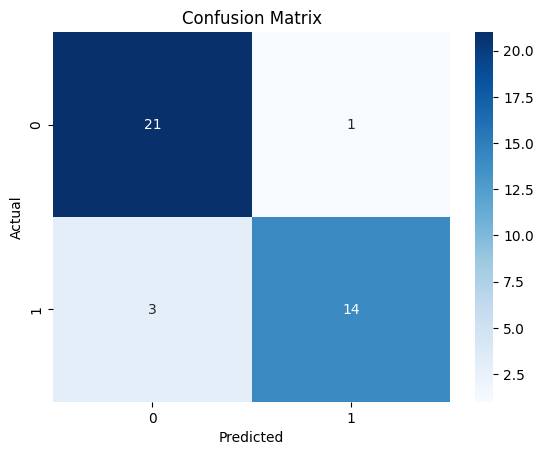

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_pred = model.predict([X_test, meta_test]) > 0.5

# Report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


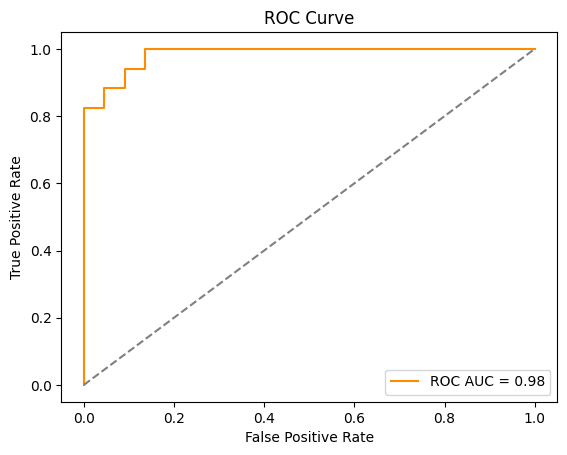

In [ ]:
from sklearn.metrics import roc_curve, auc

probs = model.predict([X_test, meta_test])
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [ ]:
model.save('cnn_mlp_diabetes_model.keras')
